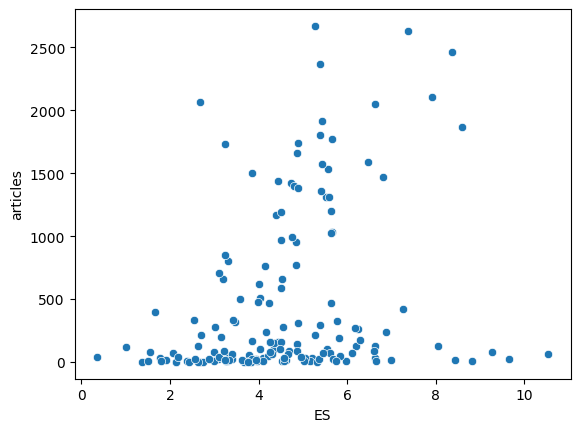

<class 'FileNotFoundError'>: [Errno 44] No such file or directory: 'temp.csv'

In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.subplots as sp
data = pd.read_csv("data6.csv")
sns.scatterplot(data=data, x='ES', y='articles')
data['levels'] = pd.cut(data['GDP'], bins=[-float('inf'), 12000, 40000, float('inf')], 
                           labels=['low', 'moderate', 'high'])
data.to_csv("temp.csv", index=False)
gdp_level_counts = data['levels'].value_counts()
print(gdp_level_counts)
print(data.head(10))


# In[12]:


#Regression Model Overview
#To quantify the impact of education spending (ES) and GDP levels on scientific output (articles), we perform a multiple linear regression:
int_model = ols('articles ~ ES * levels', data=data).fit()
print(int_model.summary())

aic_values = [int_model.aic]
def stepwise_selection(data, model, direction="backward"):
    initial_aic = model.aic
    selected_model = model
    predictors = data.columns.difference(['articles'])  
    
    while True:
        aic_values = []
        for predictor in predictors:
            if direction == "backward":
                temp_model = ols(f'articles ~ { " + ".join(predictors.difference([predictor])) }', data=data).fit()
            aic_values.append((predictor, temp_model.aic))   
        min_aic = min(aic_values, key=lambda x: x[1])
        if min_aic[1] < initial_aic:
            initial_aic = min_aic[1]
            selected_model = temp_model
            predictors = predictors.difference([min_aic[0]])  
        else:
            break  
    
    return selected_model

step_model = stepwise_selection(data, int_model)
coefs = round(step_model.params, 3)
aic = step_model.aic
print("Coefficients:", coefs)
print("AIC:", aic)
#Recommended Figure: OLS Regression Summary

#Key Observations:
#R² = 0.749, indicating that the model explains 74.9% of the variance in scientific output.
#ES alone is not a significant predictor (p = 0.67), but in high GDP countries, the interaction term ES × GDP is highly significant (p < 0.01).
#In moderate and low GDP countries, education spending does not significantly impact scientific output, suggesting that other factors, such as research infrastructure, play a crucial role.


# In[2]:


model = ols('articles ~ ES * levels', data=data).fit()
regression_table = model.summary2().tables[1]
regression_table = regression_table[['Coef.', 'Std.Err.', 'P>|t|']]

regression_table = regression_table.round(2)
regression_table = regression_table.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)
styled_table = regression_table.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)
styled_table
#Recommended Figure: Regression Coefficients Table
#Key Observations:
#Education spending significantly impacts research output only in high GDP countries (p < 0.01).
#In moderate and low GDP countries, education spending does not significantly contribute to increased research output, highlighting the importance of other factors such as research infrastructure and policy support.


# In[11]:


#Residual Analysis
#To check the validity of the regression model, we analyze residuals:
sns.lmplot(data=data, x='ES', y='articles', hue='levels', 
           ci=None,  
           scatter_kws={'s': 50},  
           line_kws={'linewidth': 2}) 
plt.xlabel('Education Spending')
plt.ylabel('articles')
plt.title('Scatter Plot with Regression Lines by Level')
plt.legend(title='levels')
plt.show()


# In[21]:


#Residual Analysis
regression_points = pd.DataFrame({
    'ES': data['ES'],
    'residual': model.resid,
    'articles_hat': model.fittedvalues,
    'levels': data['levels']
})

print(regression_points.head())
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=regression_points, x='ES', y='residual', hue='levels', ax=axes[0])
axes[0].axhline(0, color='blue', linestyle='--', linewidth=1)
axes[0].set_xlabel('Education Spending')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals vs Education Spending by Level')

sns.scatterplot(data=regression_points, x='articles_hat', y='residual', hue='levels', ax=axes[1])
axes[1].axhline(0, color='blue', linestyle='--', linewidth=1)
axes[1].set_xlabel('Predicted articles')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals vs Predicted articles by Level')

for ax in axes:
    ax.legend(title='levels')
plt.tight_layout()
plt.show()
#Figure displays the residuals versus education spending (left) and the predicted values (right) for each GDP level. 
#The assumptions of the residuals having a mean of zero and constant variance across all values of the explanatory variable (education spending), as well as the fitted values, appear to hold for high GDP countries. 
#This can be observed from the even scatter of points above and below the zero line, indicating that the residuals have a mean of zero.


# In[29]:


# Residual Histogram Analysis
regression_points['levels'] = pd.Categorical(regression_points['levels'], 
                                            categories=['high', 'moderate', 'low'], 
                                            ordered=True)
g = sns.FacetGrid(regression_points, col='levels', col_order=['high', 'moderate', 'low'])
g.map(sns.histplot, 'residual', color='orange', kde=False, bins=15, edgecolor='white')

g.set_axis_labels(x_var='Residual', y_var='Count')
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()
#Figure displays histograms of the residuals for each GDP level. Here, we can see that the residuals for high GDP countries appear to be approximately normally distributed, centered around zero. This suggests that the model performs well in capturing the relationship between education spending and research output in these countries.
#However, the residuals for moderate and low GDP countries deviate from normality, with noticeable skewness and clustering near zero. 
#This indicates that the model may be missing key explanatory variables in these groups, suggesting that factors beyond education spending, such as research infrastructure or government policies, might play a more significant role in influencing research output.


# In[ ]:


#Conclusions
#Education spending and scientific output are positively related, with higher education investment generally leading to increased research productivity. However, this relationship varies across GDP levels, requiring separate analysis for each group.
#High GDP countries exhibit a stronger relationship between education spending and research output, where an increase in education spending corresponds to a significant rise in published articles. In contrast, moderate and low GDP countries show a weaker relationship, suggesting that factors such as research infrastructure and government policy may play a more significant role in influencing scientific output.



In [ ]:
data6

$$
y_i = \alpha + \beta_{\text{es}} \cdot \text{es} + \beta_{\text{levelm}} \cdot I_{\text{levelm}}(x) + \beta_{\text{levelh}} \cdot I_{\text{levelh}}(x) + \epsilon_i
$$

$$
\mathbb{I}_{\mbox{levelm}}(x)=\left\{
\begin{array}{ll}
1 ~~~ \mbox{if level of} ~ x \mbox{th observation is moderate},\\
0 ~~~ \mbox{Otherwise}.\\
\end{array}
\right.
$$

$$
\mathbb{I}_{\mbox{levelh}}(x)=\left\{
\begin{array}{ll}
1 ~~~ \mbox{if level of} ~ x \mbox{th observation is high},\\
0 ~~~ \mbox{Otherwise}.\\
\end{array}
\right.
$$

$$\widehat{\mbox{Hwt}} = \widehat{\alpha} + \widehat{\beta}_{\mbox{Male}} \cdot \mathbb{I}_{\mbox{Male}}(x) $$

$$
\widehat{y} = \widehat{\alpha} + \widehat{\beta}_{\text{es}} \cdot \text{es} + \widehat{\beta}_{\text{levelm}} \cdot I_{\text{levelm}}(x) + \widehat{\beta}_{\text{levelh}} \cdot I_{\text{levelh}}(x) + \epsilon_i
$$